# BT4222 Assignment 1 (10 marks)

**Plagiarism Policy**

NUS takes a strict view of plagiarism and considers it a serious form of academic dishonesty. Any student found to have engaged in such misconduct will be subjected to disciplinary action by the University. Please refer to the NUS Plagiarism Policy.

For assignments in BT4222, using any AI tools to generate code is not allowed. Sharing any part of the solution among students is not allowed either. Following the recently concluded plagiarism cases, if assignments were caught with a high degree of similarity, the presumption of guilt is applied when no hard evidence can be provided by the suspect.  


**MOTIVATION**

**Part 1** According to the survey conducted among the former BT4222 students, rather than modeling, data preprocessing presented significant challenges in their projects. The thoughtfulness makes a dinstinction between project groups. In response to this, we have developed a a series of data preprocessing tasks, utilizing actual datasets from [Amazon Data 2018](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/). Constrained by the capacity and workload of an assignment, this assignment servies as a **starting point** rather than a comprehensive example as we have substantially simplied the preprocessing tasks. For instances, we simply removed missing data and outliers, selected only a subset of features and conducted superficial feature engineering while more considerate and creative strategies should be considered based on different context and specific goals in your real projects.

**Part 2** We illustrate how to conduct a very preliminary recommendation by using cosine similarity.

# Part 1 (8 Marks)

### Amazon Review Dataset Information

The [Amazon Review Data (5-core)](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/#subsets) contains review data for individual products, reduced to extract the 5-core such that each user has at least 5 reviews and each item has at least 5 reviews.

- **overall**: Rating of the product.
- **verified:** Indicates whether the user is verified.
- **reviewTime:** Datetime of the review in raw format. (e.g., 09 1, 2016)
- **reviewerID:** ID of the reviewer (e.g., A2SUAM1J3GNN3B).
- **asin:** ID of the product (e.g., 0000013714).
- **style:** A dictionary of product metadata. (e.g., {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice Blue'})
- **reviewerName:** Name of the reviewer.
- **reviewText:** Text of the review.
- **summary:** Summary of the review.
- **unixReviewTime:** Datetime of the review in Unix time. (Same timestamp as reviewTime but in a different format)
- **vote:** Helpful votes of the review.
- **image:** Image links posted after receiving the product.

### Amazon Meta Dataset Information

The [Amazon Meta Data (complete)](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/#complete-data) includes meta information for individual products, such as description, price, sales rank, brand info, and co-purchasing links.

- **category:** List of categories the product belongs to.
- **tech1:** The first tech detail table of the product.
- **description:** Description of the product.
- **fit:** The fit of the product. (Amazon uses customer feedback for size guidance. Users can choose the size feedback among the list. This feature contains a summary of different numbers of feedback across 5 size categories. Please note that fit information is available for Fashion product but not Beauty product.)
- **title:** Name of the product.
- **also_buy:** Related products also bought.
- **tech2:** The second tech detail table of the product.
- **brand:** Brand name.
- **feature:** Bullet-point format features of the product.
- **rank:** Sales rank information.
- **also_view:** Related products also viewed.
- **details:** Product details.
- **main_cat:** Category of product.
- **similar_item:** Similar product table.
- **date:** Date first available (at time of crawl).
- **price:** Price in US dollars (at time of crawl).
- **asin:** ID of the product (e.g., 0000031852).
- **imageURL:** URL of the product image.
- **imageURLHighRes:** URL of the high-resolution product image.

### Import Packages Needed

In [1]:
import os
import json
import gdown
import pandas as pd
import numpy as np
### Plot
import matplotlib.pyplot as plt
import seaborn as sns
### HTML
from bs4 import BeautifulSoup
import re
### Warnings
import warnings
### Text Preprocessing and Natural Language Processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import nltk
import re
import spacy
from wordcloud import WordCloud

### Download Data Files Needed

 For this assignment, we will work with data from the Beauty and Fashion categories, thus there are 2 review data files and 2 metadata files.

In [2]:
# Set the file names and IDs
# For Amazon Reivew Data
review_file_ids = {
    'All_Beauty_5.json': '1kommjYLqN_d4CUx0Gp_8vEDoxY1lJZ3N',
    'AMAZON_FASHION_5.json': '1tcCq8bT1jwLX8DdcGcAMPGuTGyl7iOqa',
}

# For Amazon Meta Data
meta_file_ids = {
    'meta_All_Beauty.json': '15HgucSX3RNmZ4vq4lhv_bhX6i2sAd2jU',
    'meta_AMAZON_FASHION.json': '1l-ItU19ggeSLkgahodzjnFkvK46MOU2G',
}

# Download files from Google Drive using gdown
for filename, file_id in review_file_ids.items():
    gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)
    print(f'Downloaded: {filename}')

for filename, file_id in meta_file_ids.items():
    gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)
    print(f'Downloaded: {filename}')

Downloading...
From: https://drive.google.com/uc?id=1kommjYLqN_d4CUx0Gp_8vEDoxY1lJZ3N
To: /content/All_Beauty_5.json
100%|██████████| 2.46M/2.46M [00:00<00:00, 192MB/s]


Downloaded: All_Beauty_5.json


Downloading...
From: https://drive.google.com/uc?id=1tcCq8bT1jwLX8DdcGcAMPGuTGyl7iOqa
To: /content/AMAZON_FASHION_5.json
100%|██████████| 1.41M/1.41M [00:00<00:00, 136MB/s]


Downloaded: AMAZON_FASHION_5.json


Downloading...
From: https://drive.google.com/uc?id=15HgucSX3RNmZ4vq4lhv_bhX6i2sAd2jU
To: /content/meta_All_Beauty.json
100%|██████████| 66.4M/66.4M [00:00<00:00, 82.8MB/s]


Downloaded: meta_All_Beauty.json


Downloading...
From (original): https://drive.google.com/uc?id=1l-ItU19ggeSLkgahodzjnFkvK46MOU2G
From (redirected): https://drive.google.com/uc?id=1l-ItU19ggeSLkgahodzjnFkvK46MOU2G&confirm=t&uuid=df9d84bf-3e55-485a-adae-97ab28be1116
To: /content/meta_AMAZON_FASHION.json
100%|██████████| 193M/193M [00:01<00:00, 134MB/s]

Downloaded: meta_AMAZON_FASHION.json


## Task 1 - Data Loading (0.2 marks)

Load the Amazon Review Data files (**All_Beauty_5.json** and **AMAZON_FASHION_5.json** in `review_file_ids`) into a pandas DataFrame `review_df_raw`:

1. Initialize an empty list `review_data` to store the review data.
2. Iterate through the files in `review_file_ids`.
3. For each file, read and append the JSON data to the review_data using `json.loads()` and `line.strp()`.
4. Create the DataFrame `review_df_raw` from `review_data` list.

Similarly, load the Amazon Meta Data files (**meta_All_Beauty.json** and **meta_AMAZON_FASHION.json** in `meta_file_ids`) into a pandas DataFrame `meta_df_raw` ad check the shapes of both DataFrames.

In [3]:
### Data Loading: review data (0.1 marks)
# Initialize an empty list to store the review data
review_data = []

for filename, file_id in review_file_ids.items():
    # Read and append JSON data to the review_data
    '''
    YOUR CODE HERE
    '''
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            json_object = json.loads(line)
            review_data.append(json_object)


# Create a DataFrame from the review_data
review_df_raw = pd.DataFrame(review_data)

# The shape of the Dataframe should be (8445, 12)
print("Dataframe Shape:", review_df_raw.shape)
review_df_raw.head(3)

Dataframe Shape: (8445, 12)


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5.0,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1.0,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN


In [4]:
### Data Loading: meta data (0.1 marks)
'''YOUR CODE HERE'''
meta_data = []

for filename, file_id in meta_file_ids.items():
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            json_object = json.loads(line)
            meta_data.append(json_object)

meta_df_raw = pd.DataFrame(meta_data)

# The shape of the Dataframe should be (219529, 19)
print("Dataframe Shape:", meta_df_raw.shape)
meta_df_raw.head(3)

Dataframe Shape: (219529, 19)


,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]


## Task 2 - Remove Duplicate Rows (0.4 marks)

In this assignment, we will only consider the following columns for each dataframe.
- Review Data: overall, reviewTime, reviewerID, asin, reviewText, vote.
- Meta Data: fit, title, price, asin.

1. Create two new DataFrames (`review_df` and `meta_df`) by selecting the specifc columns mentioned above from the original DataFrames `review_df_raw` and `meta_df_raw`.
2. Drop duplicate rows from each dataframe and reset the index.

In [5]:
### review_df (0.1 marks)
'''YOUR CODE HERE'''
review_df = review_df_raw[['overall', 'reviewTime', 'reviewerID', 'asin', 'reviewText', 'vote']]

### Drop duplicate rows and reset the index (0.1 marks)
'''YOUR CODE HERE'''
review_df = review_df.drop_duplicates().reset_index()


In [6]:
### meta_df (0.1 marks)
'''YOUR CODE HERE'''
meta_df = meta_df_raw[['fit', 'title', 'price', 'asin']]

### Drop duplicate rows and reset the index (0.1 marks)
'''YOUR CODE HERE'''
meta_df = meta_df.drop_duplicates().reset_index()

## Task 3 - Remove Outliers


#### Task 3.1: title (0.6 marks)

The `title` column of `meta_df`, which is of string type, contains values with unusually long lengths, indicating the presence of outliers. In this task, you are required to identify the outliers using [Z-score method](https://www.khanacademy.org/math/statistics-probability/modeling-distributions-of-data/z-scores/a/z-scores-review) (here we assume that data points with a z score higher than 3 are considered as outliers) and treat them as missing values, which will be removed in the next step.

1. Create a new column `title_length` in the DataFrame `meta_df` by calculating the length of each title. (Set the value as 0 if the correponding `title` column has NaN values.)
2. Check the statistics of `title_length` using `describe()` method.
3. Calculate the mean and standard deviation of the `title_length` column.
4. Set the threshold for identifying outliers to 3.
5. Identify outliers of the `title_length` column and set the corresponding titles to np.nan.
6. Drop the `title_length` column from the DataFrame.

**Tips**: For your project, it is important to thoroughly examine the values identified as outliers, considering the contextual information, before making any decisions. Instead of applying rigid rules to automatically detect and remove all outliers, the focus should be on understanding the reasons behind each outlier. This approach ensures a more nuanced and informed handling of outliers within the given contexts.

In [7]:
### Drop outliers: title (meta_df)
### title_length (0.1 marks)
'''YOUR CODE HERE'''
# fill nans first
meta_df['title'].fillna('', inplace=True)
meta_df['title_length'] = meta_df['title'].str.len()

### Check 'title_length' statistics using describe() (0.1 marks)
'''YOUR CODE HERE'''
meta_df['title_length'].describe()

count    218682.000000
mean        203.163114
std        3918.966900
min           0.000000
25%          56.000000
50%          71.000000
75%          84.000000
max      424341.000000
Name: title_length, dtype: float64

In [8]:
### Calculate mean and standard deviation, and set the threshold (0.1 marks)
'''YOUR CODE HERE'''
title_length_mean = meta_df['title_length'].mean()
title_length_sd = meta_df['title_length'].std()

print(f'Title length mean: {title_length_mean}')
print(f'Title length standard deviation: {title_length_sd}')

### Identify outliers and set the corresponding titles to np.nan (0.2 marks)
'''YOUR CODE HERE'''
# create another column to calculate z score
meta_df['z_score'] = (meta_df['title_length'] - title_length_mean) / title_length_sd
meta_df.loc[meta_df['z_score'] > 3, 'title'] = np.nan

### Drop the 'title_length' column (0.1 marks)
'''YOUR CODE HERE'''
# I will also drop the z_score column which i created
meta_df.drop(['title_length', 'z_score'], axis = 1, inplace=True)

meta_df.head(3)

Title length mean: 203.16311356215874
Title length standard deviation: 3918.9668996561813


,index,fit,title,price,asin
0,0,,Loud 'N Clear&trade; Personal Sound Amplifier,,6546546450
1,1,,No7 Lift &amp; Luminate Triple Action Serum 50...,$44.99,7178680776
2,2,,No7 Stay Perfect Foundation Cool Vanilla by No7,$28.76,7250468162


#### Task 3.2: price (0.6 marks)

Similarly, the `price` column of `meta_df` (of type `str`) also contains values with unusually long lengths, indicating the presence of outliers.

1. Create a new column `price_length` in the DataFrame `meta_df` by calculating the length of each price value. (Set the value as 0 if the correponding `price` column has NaN values.)
2. Check the statistics of `price_length` using `describe()` method and display its unique values.
3. Identify the outlier values by inspecting the content in `price` corresponding to the abnormal value in `price_length` and set the corresponding value of `price` to np.nan. (Hint: both null price information and abnormal price information should be treated as outliers)
4. Drop the `price_length` column from the DataFrame.

In [9]:
### Drop outliers: price (meta_df)
### price_length (0.1 marks)
'''YOUR CODE HERE'''
meta_df['price'].fillna('', inplace=True)
meta_df['price_length'] = meta_df['price'].str.len()

### Check 'price_length' statistics using describe() and print unique values (0.2 marks)
'''YOUR CODE HERE'''
print(meta_df['price_length'].describe())
print(np.unique(meta_df['price_length']))

count    218682.000000
mean          4.534324
std         130.301479
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4648.000000
Name: price_length, dtype: float64
[   0    5    6    7    9   10   13   14   15   16   17   18   19   21
 4648]


In [10]:
### Identify outliers and set the corresponding prices to np.nan (0.2 marks)
'''YOUR CODE HERE'''
# calculate mean and std of price length
price_length_mean = meta_df['price_length'].mean()
price_length_sd = meta_df['price_length'].std()

print(f'Title length mean: {price_length_mean}')
print(f'Title length standard deviation: {price_length_sd}')

# create another column to calculate z score
meta_df['z_score'] = (meta_df['price_length'] - price_length_mean) / price_length_sd

# filling those with z_score > 3 or with 0 length as outliers
meta_df.loc[meta_df['price_length'] == 0, 'price'] = np.nan
meta_df.loc[meta_df['z_score'] > 3, 'price'] = np.nan

### Drop the 'price_length' column (0.1 marks)
'''YOUR CODE HERE'''
# I will also drop the z_score column which i created
meta_df.drop(['price_length', 'z_score'], axis = 1, inplace=True)

meta_df.head(3)

Title length mean: 4.534323812659478
Title length standard deviation: 130.30147927106762


,index,fit,title,price,asin
0,0,,Loud 'N Clear&trade; Personal Sound Amplifier,NaN,6546546450
1,1,,No7 Lift &amp; Luminate Triple Action Serum 50...,$44.99,7178680776
2,2,,No7 Stay Perfect Foundation Cool Vanilla by No7,$28.76,7250468162


## Task 4 - Handle Missing Values (0.6 marks)

For Amazon Review Data `review_df`:
1. Check the count of missing values in each column and drop the rows where `reviewText` is NaN and then reset the index.
2. Fill NaN values in the `vote ` column with empty string `''`.

For Amazon Meta Data `meta_df`:
1. Check the count of missing values in each column and drop the rows where `title` or `price` is NaN and then reset the index.
2. Fill NaN values in the `fit ` column with empty string `''`.

**Tips**: Please note that here we drop rows with missing values for simplification purpose. It is a very naive way of handling missing values which may cause loss of information. For your project, you need to examine the distribution of missing values across different categories and understand the reasons behind their absence. This analysis is critical for minimizing information loss and identifying potential biases introduced by the uneven distribution of missing values.

In [11]:
### review_df
### Check the count of NaN values in each column (0.1 marks)
'''YOUR CODE HERE'''
number_of_missing = review_df.isna().sum()
print(number_of_missing)

### Drop rows where 'reviewText' has NaN values and reset index (0.1 marks)
'''YOUR CODE HERE'''
review_df = review_df.dropna(subset=['reviewText']).reset_index()

# there was a level_0 column that appeared after reset_index(). drop it.
review_df.drop(['level_0'], axis=1, inplace=True)

### Fill NaN values in the 'vote' column with an empty string '' (0.1 marks)
'''YOUR CODE HERE'''
review_df['vote'].fillna('', inplace=True)

review_df.head(3)

index            0
overall          0
reviewTime       0
reviewerID       0
asin             0
reviewText      20
vote          6578
dtype: int64


,index,overall,reviewTime,reviewerID,asin,reviewText,vote
0,0,5.0,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,As advertised. Reasonably priced,
1,1,5.0,"11 14, 2013",A3H7T87S984REU,B0000530HU,Like the oder and the feel when I put it on my...,
2,2,1.0,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,I bought this to smell nice after I shave. Wh...,


In [12]:
### meta_df
### Check the count of NaN values in each column (0.1 marks)
'''YOUR CODE HERE'''
number_of_missing = meta_df.isna().sum()
print(number_of_missing)

### Drop rows where 'title' or 'price' has NaN values and reset index (0.1 marks)
'''YOUR CODE HERE'''
meta_df = meta_df.dropna(subset=['title', 'price']).reset_index()

# there was a level_0 column that appeared after reset_index(). drop it.
meta_df.drop(['level_0'], axis=1, inplace=True)

### Fill NaN values in the 'fit' column with an empty string '' (0.1 marks)
'''YOUR CODE HERE'''
meta_df['fit'].fillna('', inplace=True)

meta_df.head(3)

index         0
fit      181367
title       430
price    189718
asin          0
dtype: int64


,index,fit,title,price,asin
0,1,,No7 Lift &amp; Luminate Triple Action Serum 50...,$44.99,7178680776
1,2,,No7 Stay Perfect Foundation Cool Vanilla by No7,$28.76,7250468162
2,4,,Lacto Calamine Skin Balance Oil control 120 ml...,$12.15,7414204790


## Task 5 - Feature Engineering

#### Task 5.1: Merge Two DataFrames (0.9 marks)

1. Based on the `asin` values (product IDs), check the match between `review_df` and `meta_df` by answering the questions below. (Hint: try using the `set()` function)

2. Merge the `review_df` and `meta_df` DataFrames into `data_df` by performing a left join of `meta_df` to `review_df` based on the `asin` column.

3. Remove rows with missing values and reset the index.

**Tips**: Here we drop rows with missing values for simplification purpose. For your project, you need to examine the distribution of missing values and understand the reasons behind their absence.

In [13]:
### Questions:
# 1) Calculate the number of products with product information (asin in meta_df)
# but no review information (asin not in review_df): YOUR ANSWER HERE (0.1 marks)
'''YOUR CODE HERE'''
print(len(set(meta_df['asin']) - set(review_df['asin'])))

28799


In [14]:
# 2) Calculate the number of products with review information (asin in review_df)
# but no product information (asin not in meta_df): YOUR ANSWER HERE (0.1 marks)
'''YOUR CODE HERE'''
print(len(set(review_df['asin']) - set(meta_df['asin'])))

46


In [17]:
# 3) For products with review information (asin in review_df) but no product
# information (asin not in meta_df), what is the number of reviews for each product?
# Create a DataFrame with columns 'asin' and 'reviewCount' to show the result.
# Sort the DataFrame by 'reviewCount' in descending order and display the top 5 rows. (0.5 marks)
'''YOUR CODE HERE'''
products_with_reviewinfo_only = set(review_df['asin']) - set(meta_df['asin'])
asin_ls = []
reviewCount_ls = []

for asin in products_with_reviewinfo_only:
    asin_ls.append(asin)
    reviewCount_ls.append(review_df.apply(lambda x: x == asin).sum().sum())

products_with_reviewinfo_only_df = pd.DataFrame({
    'asin': asin_ls,
    'reviewCount' : reviewCount_ls
})

# sort in desc order
products_with_reviewinfo_only_df = products_with_reviewinfo_only_df.sort_values(ascending=False, by='reviewCount')
products_with_reviewinfo_only_df.head(5)

,asin,reviewCount
8,B0012Y0ZG2,878
25,B000URXP6E,856
29,B001OHV1H4,488
20,B0009RF9DW,391
9,B000FI4S1E,391


In [18]:
### data_df (0.1 marks)
'''YOUR CODE HERE'''
# explicitly change dtype of asin column to allow for join
review_df['asin'] = review_df['asin'].astype('str')
meta_df['asin'] = meta_df['asin'].astype('str')

# rename `index` in both dataframes in order to perform join without ambiguity
review_df = review_df.rename(columns={'index': 'review_index'})
meta_df = meta_df.rename(columns={'index': 'meta_index'})

# perform left join
data_df = review_df.join(meta_df.set_index('asin'), how='left', on='asin')

### Remove rows with missing values and reset the index (0.1 marks)
'''YOUR CODE HERE'''
data_df.dropna(inplace=True)
data_df.reset_index(inplace=True)

data_df.head(3)

,index,review_index,overall,reviewTime,reviewerID,asin,reviewText,vote,meta_index,fit,title,price
0,4,4,5.0,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,If you ever want to feel pampered by a shampoo...,3,111.0,,Citre Shine Moisture Burst Shampoo - 16 fl oz,$23.00
1,5,5,5.0,"05 16, 2010",A24HQ2N7332W7W,B00006L9LC,"If you know the scent of Diva, you'll LOVE thi...",,111.0,,Citre Shine Moisture Burst Shampoo - 16 fl oz,$23.00
2,6,6,5.0,"05 7, 2018",A2G90R2ZU6KU5D,B00006L9LC,Got this shampoo as a solution for my wife's d...,,111.0,,Citre Shine Moisture Burst Shampoo - 16 fl oz,$23.00


#### Task 5.2: reviewTime (0.1 marks)

Convert `reviewTime` Column to Datetime using `pd.to_datetime()`.


In [19]:
### reviewTime (0.1 marks)
'''YOUR CODE HERE'''
data_df['reviewTime'] = pd.to_datetime(data_df['reviewTime'])

#### Task 5.3: fit (0.5 marks)

Amazon utilizes customer feedback for size guidance, allowing users to select the size feedback from a list. The `fit` column contains a summary of different numbers of feedback across five size categories for each product. As this feature presents size feedback in string format with HTML tags, we need to use feature engineering to extract useful information.

**Hint**: You are given the `extract_size_feedback` function that can extract the size feedback information using the HTML tags provided in the `fit` column. This function takes the HTML string as input and returns a dictionary with size labels as keys and corresponding feedback counts as values.

1. Select one HTML string value from the `fit` column (`example_html`) where the value is not empty.
2. Apply the `extract_size_feedback` function on the HTML string (`example_html`) to check the function output.
3. Create a list of the unique size feedback categories from the `fit` column by **iterating** over each HTML string in the `fit` column of the `data_df` DataFrame and extracting the size feedback categories.
4. For each size feedback category, use the `apply` function to create a new column (named by the size feedback category), the cell value should be the corresponding number of feedback of this size category for this product extracted by `extract_size_feedback` (If the `fit` column is empty, set the count to 0.)
5. Drop the `fit` column.

In [20]:
def extract_size_feedback(html_string):
    """
    Extracts size feedback information from HTML string.

    Parameters:
    - html_string (str): The HTML string containing size feedback information.

    Returns:
    - dict: A dictionary with size labels as keys and corresponding feedback counts as values.
    """
    # Parse HTML with BeautifulSoup
    soup = BeautifulSoup(html_string, 'html.parser')

    # Initialize a dictionary to store size feedback
    size_feedback = {}

    # Find all rows in the histogram
    rows = soup.find_all('tr', class_='a-histogram-row')

    # Extract information for each size category
    for row in rows:
        # Extract size label
        size_label = row.find('span').get_text(strip=True)

        # Extract count
        count = int(row.find('span').findNext('span').get_text(strip=True).replace(',', ''))

        size_feedback[size_label] = count

    return size_feedback

In [21]:
### fit
### example_html (0.1 marks)
'''YOUR CODE HERE'''
# obtaining non-empty html
for i in meta_df['fit']:
    if len(i) > 0:
        example_html = i
        break

### Apply the extract_size_feedback on example_html (0.1 marks)
'''YOUR CODE HERE'''

extract_size_feedback(example_html)

{'Too small': 13,
 'Somewhat small': 6,
 'Fits as expected': 50,
 'Somewhat large': 2,
 'Too large': 0}

In [22]:
### List of the unique size feedback categories (0.1 marks)
'''YOUR CODE HERE'''
unique_size_feedback_categories = set()

for item in meta_df['fit']:
    if len(item) == 0:
        continue
    else:
        unique_size_feedback_categories.update(extract_size_feedback(item).keys())
unique_keys_list = list(unique_size_feedback_categories)

print(unique_keys_list)

['Demasiado grande', 'Too large', 'Too small', 'Somewhat large', 'Talla del modo esperado', 'Un poco grande', 'Demasiado pequeo', 'Somewhat small', 'Un poco pequeo', 'Fits as expected']


In [23]:
### Create a new column in data_df for each size feedback category (0.1 marks)
'''YOUR CODE HERE'''
# obtain `actual_fit` from `fit` metadata
data_df['actual_fit'] = data_df['fit'].apply(extract_size_feedback)

for category in unique_keys_list:
    data_df[category] = 0

# Update the DataFrame with the dictionary values
for index, row in data_df.iterrows():
    for key, value in row['actual_fit'].items():
        if key in data_df.columns:
            data_df.at[index, key] = value

# for category in unique_keys_list:
    # Use apply with a lambda function to count occurrences
    # data_df[category] = data_df['fit'].apply(lambda x: x.count(category) if x else 0)

### Drop the original 'fit' column (0.1 marks)
'''YOUR CODE HERE'''
data_df.drop(['fit', 'actual_fit'], axis=1, inplace=True)

data_df.head(3)

,index,review_index,overall,reviewTime,reviewerID,asin,reviewText,vote,meta_index,title,...,Demasiado grande,Too large,Too small,Somewhat large,Talla del modo esperado,Un poco grande,Demasiado pequeo,Somewhat small,Un poco pequeo,Fits as expected
0,4,4,5.0,2011-05-06,A3SFRT223XXWF7,B00006L9LC,If you ever want to feel pampered by a shampoo...,3,111.0,Citre Shine Moisture Burst Shampoo - 16 fl oz,...,0,0,0,0,0,0,0,0,0,0
1,5,5,5.0,2010-05-16,A24HQ2N7332W7W,B00006L9LC,"If you know the scent of Diva, you'll LOVE thi...",,111.0,Citre Shine Moisture Burst Shampoo - 16 fl oz,...,0,0,0,0,0,0,0,0,0,0
2,6,6,5.0,2018-05-07,A2G90R2ZU6KU5D,B00006L9LC,Got this shampoo as a solution for my wife's d...,,111.0,Citre Shine Moisture Burst Shampoo - 16 fl oz,...,0,0,0,0,0,0,0,0,0,0


#### Task 5.4: price (0.6 marks)

The `price` column contains the price information of each product in string form. For each product, its `price` can be either a single price or a price range. For this task, you are required to extract the price information by the following steps:

1. Use the `apply` function on the `price` column of the DataFrame (`data_df`) to create a list (`len_idx`) containing the length of each value in the `price` column (converted to strings). The length represents the number of characters in each price value.
2. Define a function `extract_price_range` that takes a price string as input and returns a dictionary with 'min' and 'max' keys representing the minimum and maximum price values. (If the `price` is a single value, set minimum and maximum values to be the same.)
3. Use the `apply` function to create new columns (`min_price` and `max_price`) in the DataFrame by extracting minimum and maximum prices from the `price` column using the defined function.
4. Drop the `price` column.

In [24]:
### price
### len_idx (0.1 marks)
'''YOUR CODE HERE'''
len_idx = data_df['price'].apply(lambda x: len(x))
print(len_idx)

0        6
1        6
2        6
3        6
4        6
        ..
3549    16
3550    16
3551    16
3552    16
3553    16
Name: price, Length: 3554, dtype: int64


In [25]:
test_range = '$54.95 - $199.95'
test_single = '$23.00'
print(test_range.split())
print(test_single.split())

# we can observe the difference in lengths between a range price and single-valued price. we will use this logic for our function in the next cell.

['$54.95', '-', '$199.95']
['$23.00']


In [26]:
### Define function to extract price range (0.2 marks)
def extract_price_range(price):
    min_price = None
    max_price = None
    '''
    YOUR CODE HERE
    '''
    price_list = price.split()
    if len(price_list) < 3 :
        clean_price = re.search(r"\$(\d+\.\d+)", price_list[0]).group(1)
        min_price = clean_price
        max_price = clean_price
    else:
        clean_min = re.search(r"\$(\d+\.\d+)", price_list[0]).group(1)
        min_price = clean_min
        clean_max = re.search(r"\$(\d+\.\d+)", price_list[len(price_list)-1]).group(1)
        max_price = clean_max
    return {'min':min_price, 'max':max_price}

In [27]:
# testing
print(extract_price_range(test_range))
print(extract_price_range(test_single))

{'min': '54.95', 'max': '199.95'}
{'min': '23.00', 'max': '23.00'}


In [28]:
### Create two new colulmns 'min_price' and 'max_price' (0.2 marks)
'''YOUR CODE HERE'''
data_df['min_price'] = data_df['price'].apply(lambda x: extract_price_range(x)['min'])
data_df['max_price'] = data_df['price'].apply(lambda x: extract_price_range(x)['max'])
### Drop the original 'price' column (0.1 marks)
'''YOUR CODE HERE'''
data_df.drop(['price'], axis=1, inplace=True)

#### Task 5.5: vote (0.1 marks)

Convert the `vote` from string to numeric values. (If the `vote` column is empty, set the count to 0.)

In [29]:
non_empty = []
for i in data_df['vote']:
    if len(i)>0 :
        if i not in non_empty:
            non_empty.append(i)
print(non_empty)

['3', '5', '4', '6', '2', '9', '19', '16', '8', '20', '30', '7', '48', '12', '186', '14', '35', '10', '22', '21', '11']


In [30]:
### vote (0.1 marks)
'''YOUR CODE HERE'''
data_df['vote'] = pd.to_numeric(data_df['vote'], errors='coerce')
data_df['vote'].fillna(0, inplace=True)
data_df['vote'] = data_df['vote'].astype('int')

#### Task 5.6: reviewText (0.8 marks)

Text processing is vital in NLP tasks to clean and structure raw text data. For this task, define a function `process_text` that takes a textual value as input and applies the following processing steps in sequence:

1. Convert the input text to lowercase using the `lower()` function.

2. Tokenize the lowercase text using the `word_tokenize` function from the NLTK library.

3. Create a list (`alphabetic_tokens`) containing only alphabetic tokens using a list comprehension with a regular expression match.

4. Remove stopwords words
  - Obtain a set of English stopwords using the `stopwords.words('english')` method
  - Define a list of **at least 5 words** that should not be removed and provide your reasoning in comments. (**Hint**: for **sentiment analysis**, some words should not be removed from the text as they may affect the sentiment of the review (e.g.: "no", "not"))
  - Remove the stopwords (excluding those that should not be removed) from `tokens` column.

5. Apply lemmatization to each token in the list (`lemmatized_words`) using the `lemmatize` method.

6. Join the lemmatized tokens into a single processed text using the `join` method and return the processed text.

Creating a new column `processed_review` in data_df by applying the `process_text` function to each element in the `reviewText` column.


In [31]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [32]:
from nltk.tokenize import RegexpTokenizer

### Define function to process text (0.6 marks)
def process_text(text):
    processed_text = " "
    '''
    YOUR CODE HERE
    '''
    # lower
    text_lower = text.lower()
    # tokenize (keep alphabetical only)
    tokenizer = RegexpTokenizer(r"[A-Za-z']+[A-Za-z]|[A-Za-z]+")
    tokens = tokenizer.tokenize(text_lower)
    # define stopwords, removing some
    english_stopwords = stopwords.words('english')
    stopwords_to_keep = ['not', 'no', "don't", "won't", "didn't", "but", "weren't", "wouldn't"]
    for i in stopwords_to_keep:
        english_stopwords.remove(i)
    tokens = [word for word in tokens if word not in english_stopwords]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    processed_text = processed_text.join(tokens)
    return processed_text

In [33]:
### processed_review (0.1 marks)
'''YOUR CODE HERE'''
data_df['processed_review'] = data_df['reviewText'].apply(lambda x: process_text(x))

In [34]:
### Your Reasoning Here (0.1 marks)
"""I kept specific words in `stopwords_to_keep` because those words carry negative connotation (don't) and a change in review sentiments (e.g. but) which can indicate the tone of the review, and it is important that they are not removed."""

"I kept specific words in `stopwords_to_keep` because those words carry negative connotation (don't) and a change in review sentiments (e.g. but) which can indicate the tone of the review, and it is important that they are not removed."

## Task 6: Visualization

#### Task 6.1: review length and overall ratings (0.6 marks)

**Purpose**: check if the review length varies by the overall ratings

1. Create a new DataFrame (`positive_vote_df`) by keeping rows from data_df where the `vote` column is greater than 0.
2. Add a new column `reviewText_length` to positive_vote_df that represents the length of each review in terms of the number of words (use str.split(" ")).
3. Remove rows from `positive_vote_df` where the `reviewText_length` is greater than or equal to 300. (**Tips**: Here the threshold of 300 is selected for simplification purpose. For your project, you should explicitly claim and justify why you select certain threshold for excluding data points from the dataset.)
4. Create **a box plot** using the seaborn library to visualize the distribution of review lengths (`reviewText_length`) for different overall ratings (`overall`). Set `showmeans=True` to display mean markers.
5. Set a title for the plot to describe the content being visualized. Label the x-axis as 'Overall Ratings' and the y-axis as 'Review Length'.
6. Write 1-2 sentences about the insight you obtained based on the observation.

In [35]:
### positive_vote_df (0.1 marks)
'''YOUR CODE HERE'''
positive_vote_df = data_df[data_df['vote'] > 0]

### reviewText_length (0.1 marks)
'''YOUR CODE HERE'''
positive_vote_df = positive_vote_df.copy()
positive_vote_df.loc[:, 'reviewText_length'] = positive_vote_df['reviewText'].apply(lambda x: len(x.split(" ")))

### Remove rows with reviewText length greater than or equal to 300 from positive_vote_df (0.1 marks)
'''YOUR CODE HERE'''
positive_vote_df = positive_vote_df[positive_vote_df['reviewText_length'] < 300]

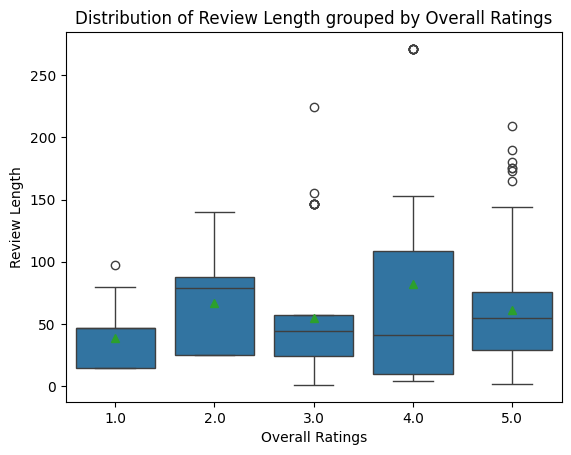

In [36]:
### Plot (0.2 marks)
'''YOUR CODE HERE'''
ax = sns.boxplot(positive_vote_df, x='overall', y='reviewText_length', showmeans=True)
ax.set_title('Distribution of Review Length grouped by Overall Ratings')
ax.set_xlabel('Overall Ratings')
ax.set_ylabel('Review Length')
plt.show()

In [37]:
### YOUR INSIGHTS HERE (0.1 marks)
"""There are no outlier review lengths for 2 star ratings. The mean review length for 3 and 4 star ratings are similar."""

'There are no outlier review lengths for 2 star ratings. The mean review length for 3 and 4 star ratings are similar.'

#### Task 6.2: size feedback and overall ratings (1.1 marks)
**Purpose**: Check if the distribution of fitting feedback differs by the overall rating

1. Create a list named `size_feedback_columns` containing the 5 size feedback categories: `'Too small', 'Somewhat small', 'Fits as expected', 'Somewhat large', and 'Too large'`.

2. Generate a new dataframe from `data_df` by keeping the rows where the **sum** of the size feedback columns is greater than 0 (set as `size_feedback_data`).

3. Group the `size_feedback_data` DataFrame by the `asin` column and calculate the mean of `overall` (rating) and the mean of each size feedback column (set as `product_level_data`).

4. We would like to check the percentage of fit and unfit by creating two new columns `fit_perc` and `unfit_perc` in the `product_level_data` DataFrame based on the formulas below:
  - `fit_perc` = `Fits as expected` / (`Too small`+`Somewhat small`+`Fits as expected`+`Somewhat large`+`Too large`)
  - `unfit_perc` = `Too small`+`Too large` / (`Too small`+`Somewhat small`+`Fits as expected`+`Somewhat large`+`Too large`)

6. Create two scatter plots side by side (Hint: use `plt.subplots()`):
  - Create a scatter plot on the left with 'Overall' (`overall`) on the x-axis and 'Fit Percentage' (`fit perc`) on the y-axis. Use blue color and add labels and the legend.
  - Create a scatter plot on the right with 'Overall' (`overall`) on the x-axis and 'Unfit Percentage' (`unfit perc`) on the y-axis. Use red color and add labels and a legend.

7. Write 1-2 sentences about the insight you obtained based on the observation.

In [38]:
### List of size feedback columns (0.1 marks)
'''YOUR CODE HERE'''
size_feedback_columns = ['Too small', 'Somewhat small', 'Fits as expected', 'Somewhat large', 'Too large']

### size_feedback_data (0.1 marks)
'''YOUR CODE HERE'''
size_feedback_data = data_df[data_df[size_feedback_columns].sum(axis=1) > 0]

### product_level_data (0.1 marks)
'''YOUR CODE HERE'''
columns_to_agg = ['Too small', 'Somewhat small', 'Fits as expected', 'Somewhat large', 'Too large', 'overall']
product_level_data = size_feedback_data.groupby('asin')[columns_to_agg].mean()

### fit_perc and unfit_perc (0.2 marks)
'''YOUR CODE HERE'''
product_level_data['fit_perc'] = product_level_data['Fits as expected'] / np.sum(product_level_data[['Too small', 'Somewhat small', 'Fits as expected', 'Somewhat large', 'Too large']], axis=1)
product_level_data['unfit_perc'] = np.sum(product_level_data[['Too small', 'Too large']], axis=1) / np.sum(product_level_data[['Too small', 'Somewhat small', 'Fits as expected', 'Somewhat large', 'Too large']], axis=1)

product_level_data.head(3)

,Too small,Somewhat small,Fits as expected,Somewhat large,Too large,overall,fit_perc,unfit_perc
asin,,,,,,,,
B000K2PJ4K,64.0,61.0,296.0,6.0,3.0,4.200000,0.688372,0.155814
B000KPIHQ4,73.0,128.0,7641.0,233.0,134.0,4.142857,0.930808,0.025216
B000V0IBDM,73.0,128.0,7644.0,233.0,134.0,4.142857,0.930833,0.025207


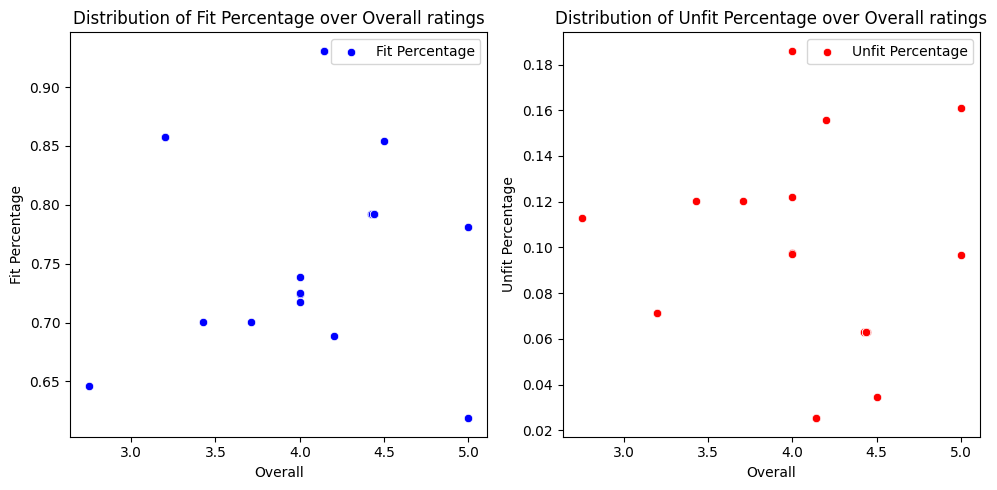

In [39]:
### Plot (0.5 marks)
'''YOUR CODE HERE'''
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(data=product_level_data, x='overall', y='fit_perc', ax=axs[0], color='blue', label='Fit Percentage')
axs[0].set_title('Distribution of Fit Percentage over Overall ratings')
axs[0].set_xlabel('Overall')
axs[0].set_ylabel('Fit Percentage')
axs[0].legend()

sns.scatterplot(data=product_level_data, x='overall', y='unfit_perc', ax=axs[1], color='red', label='Unfit Percentage')
axs[1].set_title('Distribution of Unfit Percentage over Overall ratings')
axs[1].set_xlabel('Overall')
axs[1].set_ylabel('Unfit Percentage')
axs[1].legend()

plt.tight_layout()
plt.show()

In [40]:
### YOUR INSIGHTS HERE (0.1 marks)
"""Across all overall ratings, the fit percentage is higher than the unfit percentages, as seen from how the fit percentages are all above 0.60, while the unfit percentages are all below 0.20"""

'Across all overall ratings, the fit percentage is higher than the unfit percentages, as seen from how the fit percentages are all above 0.60, while the unfit percentages are all below 0.20'

#### Task 6.3: word cloud (0.9 marks)
**Purpose**: A word cloud visually summarizes the most frequently occurring words in a product review, offering a quick and engaging way to highlight key themes, identify prevalent sentiments, and provide a concise overview of customer feedback.

1. Define a function `extract_adjectives` that takes a piece of text as input, tokenizes it, performs part-of-speech tagging using `pos_tag`, and extracts adjectives (tag: "JJ").
2. Define a function `generate_word_cloud_adjectives` that takes a text, extracts adjectives, and generates a Word Cloud for visualization. Set the params as `width=800, height=400, background_color='white'`.
3. Create two variables `low_star_reviews` and `high_star_reviews` by combining all the processed_reviews for low and high ratings in `data_df` respectively (Hint: use `" ".join()`). Use thresholds overall==1 for low ratings and overall==5 for high ratings.
4. Apply the `generate_word_cloud_adjectives` function to generate Word Clouds for adjectives in `low_star_reviews` and `high_star_reviews`.
5. Observe the generated Word Clouds and analyze the adjectives used in low and high rating reviews.

In [41]:
# Download NLTK resources for part-of-speech tagging
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [42]:
### Define function to extract adjectives (0.3 marks)
def extract_adjectives(text):
    adjectives = []
    '''
    YOUR CODE HERE
    '''
    tokens = word_tokenize(text)
    tagged_text = nltk.pos_tag(tokens)
    for i in tagged_text:
        if i[1] == 'JJ':
            adjectives.append(i[0])
    return adjectives

In [43]:
### Define function to generate Word Cloud for adjectives (0.3 marks)
def generate_word_cloud_adjectives(text, title):
    wordcloud = None
    '''
    YOUR CODE HERE
    '''
    adjectives = extract_adjectives(text)
    # Concatenate all text into a single string
    text = " ".join(row for row in adjectives)
    # Plot the Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

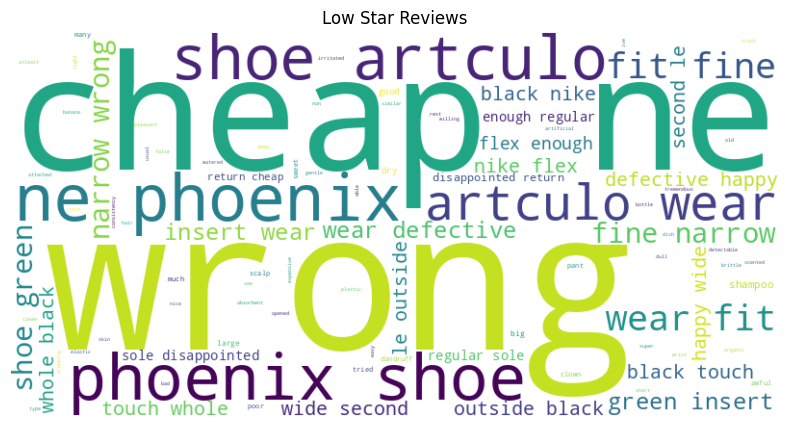

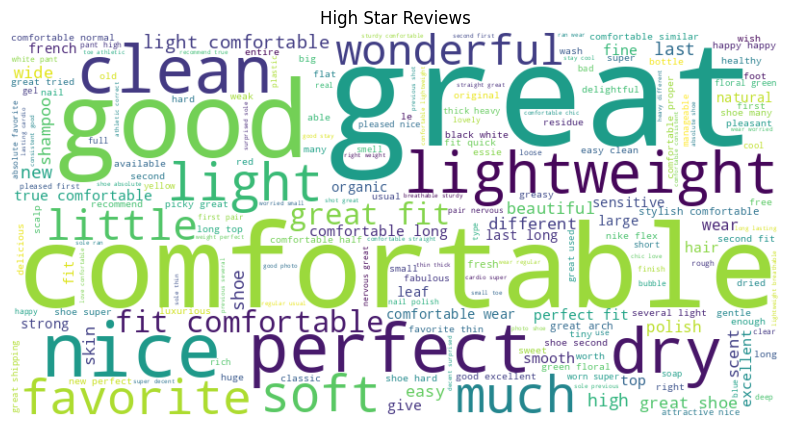

In [44]:
### Create low_star_reviews and high_star_reviews (0.1 marks)
'''YOUR CODE HERE'''
low_star_reviews = " ".join(row for row in data_df[data_df['overall'] == 1]['processed_review'])
high_star_reviews = " ".join(row for row in data_df[data_df['overall'] == 5]['processed_review'])

### Generate two Word Clouds (0.1 marks)
'''YOUR CODE HERE'''
generate_word_cloud_adjectives(low_star_reviews, 'Low Star Reviews')
generate_word_cloud_adjectives(high_star_reviews, 'High Star Reviews')

In [45]:
### YOUR INSIGHTS HERE (0.1 marks)
"""The adjectives in the high star reviews have a positive connotation, where the most frequently used words include great, good and comfortable. Those in the low star reviews have a negative connotation, and the most frequently used words include wrong and cheap."""

'The adjectives in the high star reviews have a positive connotation, where the most frequently used words include great, good and comfortable. Those in the low star reviews have a negative connotation, and the most frequently used words include wrong and cheap.'

# Part 2 (2 Marks)

In this section, you are required to do content based filtering for movie recommendation.

For the purposes of this section, the dataset used is the IMDB_top_1000.csv.

### Content Based Filtering Task Introduction

Content based filtering uses item features to generate recommendations. The underlying algorithm will extract features from an item and compare it to a new item. If the two items are similar then the new item is recommended.

<img src="https://drive.google.com/uc?id=1WvHQ4x5ZLTjacyYZdyFcJLxlt1XegVnN" width="400"></img>

### Import Packages Needed

In [46]:
import pandas as pd
import numpy as np
### Plot
import matplotlib.pyplot as plt
import seaborn as sns
### Natural Language Processing
from sklearn.feature_extraction.text import TfidfVectorizer

### Download Data File Needed

In [47]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FgXwJNw1Pg2WtkWCYZCnsZGrHxpTvCVP' -O IMDB_top_1000.csv

--2024-02-03 13:25:20--  https://docs.google.com/uc?export=download&id=1FgXwJNw1Pg2WtkWCYZCnsZGrHxpTvCVP
Resolving docs.google.com (docs.google.com)... 142.250.125.102, 142.250.125.138, 142.250.125.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.125.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1FgXwJNw1Pg2WtkWCYZCnsZGrHxpTvCVP&export=download [following]
--2024-02-03 13:25:20--  https://drive.usercontent.google.com/download?id=1FgXwJNw1Pg2WtkWCYZCnsZGrHxpTvCVP&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.121.132, 2607:f8b0:4001:c19::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.121.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98421 (96K) [application/octet-stream]
Saving to: ‘IMDB_top_1000.csv’

IMDB_top_1000.csv   100%[===================>]  96.11K  --.-KB/

### Data Loading

For the purpose of this section, we will only consider two columns: `Title` and `Description`.

In [48]:
# Data Loading
raw_df = pd.read_csv("/content/IMDB_top_1000.csv")
# raw_df = pd.read_csv("IMDB_top_1000.csv")
movie_df = raw_df[['Title', 'Description']].copy()
print(movie_df.shape)
movie_df.head(5)

(285, 2)


,Title,Description
0,The Shawshank Redemption,Two imprisoned men bond over a number of years...
1,The Godfather,The aging patriarch of an organized crime dyna...
2,The Dark Knight,When the menace known as the Joker wreaks havo...
3,The Godfather: Part II,The early life and career of Vito Corleone in ...
4,The Lord of the Rings: The Return of the King,Gandalf and Aragorn lead the World of Men agai...


### Task 1: TF-IDF

TF-IDF is employed here to convert textual information (movie descriptions) into numerical vectors. This allows for content-based filtering by measuring the similarity between movies based on the importance and uniqueness of terms.

#### Task 1.1: TfidfVectorizer (0.3 marks)

1. Create a TfidfVectorizer `tfidf` with English stop words.
2. Fit and transform the `Description` column of `movie_df` into `tfidf_scores`.
3. Check the shape of the resulting TF-IDF matrix (`tfidf_scores`) and explain the two dimension values.

In [49]:
### tfidf (0.2 marks)
'''YOUR CODE HERE'''
tfidf = TfidfVectorizer(stop_words='english')
tfidf_scores = tfidf.fit_transform(movie_df['Description'])

In [50]:
movie_df.shape

(285, 2)

In [51]:
### Check the shape of the resulting TF-IDF matrix (tfidf_scores)
### and explain the two dimension values (0.1 marks)
'''YOUR CODE HERE'''
print(tfidf_scores.shape)

### Row: 285 -- this refers to the number of rows that were present in the movie_df dataset, which means there are 285 movie reviews.
### Column: 2363 -- this refers to the number of unique words across all movie review descriptions, identified by the tfidf vectorizer.

(285, 2363)


### Task 2: Cosine Similarity

#### Task 2.1: cos_sim() (0.3 marks)

Define the `cos_sim()` function which takes two vectors: `vector_a` and `vector_b` (e.g.: `np.array([1, 2, 3])`) as inputs and returns the cosine similarity value of the two vectors (Hint: use np.dot() and np.linalg.norm()).

In [52]:
### Define function to calculate cosine similarity (0.3 marks)
def cos_sim(vector_a, vector_b):
    similarity = 0
    '''
    YOUR CODE HERE
    '''
    dot_product = np.dot(vector_a, vector_b)
    norm_vector_a = np.linalg.norm(vector_a)
    norm_vector_b = np.linalg.norm(vector_b)
    similarity = dot_product / (norm_vector_a * norm_vector_b)
    return similarity

#### Task 2.2: pairwise_cos_sim() (0.2 marks)

1. Define the `pairwise_cos_sim()` function to calculate the pairwise cosine similarity between a collection of vectors by making use of the `cos_sim()` defined in the previous task. The function takes `vectors` (e.g.: `np.array([[1,2,3],[1,2,3]])`) as input and returns the cosine similarity matrix (e.g.: `np.array([[1,1],[1,1]])`).
2. Apply the `pairwise_cos_sim()` function to `tfidf_scores.to_array()` to get the pairwise cosine similarity (`tfidf_cosine_sim`).

In [53]:
### Define function to calculate pairwise cosine similarity (0.1 marks)
def pairwise_cos_sim(vectors):
    num_vectors = len(vectors)
    similarity_matrix = np.zeros((num_vectors, num_vectors))
    # similarity_matrix = None
    '''
    YOUR CODE HERE
    '''
    # Iterate over all pairs of vectors
    for i in range(num_vectors):
        for j in range(i, num_vectors):
            similarity = cos_sim(vectors[i], vectors[j])
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity
    return similarity_matrix

In [54]:
### tfidf_cos_sim (0.1 marks)
'''YOUR CODE HERE'''
tfidf_cos_sim = pairwise_cos_sim(tfidf_scores.toarray())
print(tfidf_cos_sim)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


#### Task 2.3: top cosine similarity pair (0.5 marks)

1. Find the top cosine similarity score (`top_cos_sim`) between two different movie descriptions by flattening the `tfidf_cos_sim` into a 1D array, sorting the values by `sorted()`, and indexing to retrieve the cosine similarity score.
2. Explain the reason for the index chosen in step 1.
3. Use `np.argwhere` to find the indices where the maximum value (`top_cos_sim`) occurs in `tfidf_cos_sim`.
4. Print the title and the movie description of the movie pair identified
and explain the intuitive reason for the high cosine similarity score.

In [55]:
### top_cos_sim (0.1 marks)
'''YOUR CODE HERE'''
flattened = np.sort(tfidf_cos_sim.flatten())[::-1]

index_tracker = 0
top_cos_sim = 0
for i in range(len(flattened)):
    if flattened[i] < 1:
        index_tracker = i
        top_cos_sim = flattened[i]
        break
print(f'Index of the top cosine similarity: {index_tracker}')
print(f'Top cosine similarity: {top_cos_sim}')

### Explain the reason for choosing the index: (0.1 marks)
# My code above finds the maximum cosine similarity that is not equals to 1. This is because those cosine similarities that are = 1 show the similarity of a movie description with itself.
# Hence I looped through the flattened sorted list and chose the first index that is smaller that 1.

Index of the top cosine similarity: 285
Top cosine similarity: 0.47516870053040383


In [56]:
### Find the indices of top_cos_sim (0.1 marks)
'''YOUR CODE HERE'''
indices = np.argwhere(tfidf_cos_sim == top_cos_sim)
print(f'Indices where top_cos_sim occurs: {indices}')

Indices where top_cos_sim occurs: [[ 33 265]
 [265  33]]


In [57]:
### Print the title and the movie description of the movie pair identified (0.1 marks)
'''YOUR CODE HERE'''
for i in range(int(len(indices)/2)):
    print(movie_df.iloc[indices[i][0]]['Title'])
    print(movie_df.iloc[indices[i][0]]['Description'])
    print(movie_df.iloc[indices[i][1]]['Title'])
    print(movie_df.iloc[indices[i][1]]['Description'])

### Explain the reason: (0.1 marks)
# The description of both movies use similar keywords like "undercover cop" and "mole". The descriptions are also similar in terms of the meaning -- "identify each other" vs "Their objectives are the same"

The Departed
An undercover cop and a mole in the police attempt to identify each other while infiltrating an Irish gang in South Boston.
Infernal Affairs
A story between a mole in the police department and an undercover cop. Their objectives are the same: to find out who is the mole, and who is the cop.


### Task 3: Movie Recommendation

#### Task 3.1: recommend_movies() (0.6 marks)

Define the `recommend_movies()` function with appropriate parameters. The function should take `data` (movie information Dataframe in the form of `movie_df`), `movie_name` (the title of the movie which should be within the input movie information Dataframe), `similarity_matrix` (matrix with pairwise cosine similarity scores like `tfidf_cosine_sim`) and an optional parameter `top_k` (the number of top recommendations, set the default value to be 5) as inputs and returns a Dataframe with the top k recommended movies:
1. Find and print the index of the input movie within the input DataFrame based on `Title` column.
2. Retrieve the cosine similarity scores for the input movie based on the index.
3. Sort the movie indices based on the similarity scores in descending order by using `np.argsort()`.
4. Extract the movie indices for the top k recommendation. (**Hint**: Be careful of the indices as we should not recommend the input movie back to the user.)
5. Use DataFrame indexing to retrieve a subset of the `data` DataFrame as `rec_df` which contains the details of the recommended movies.
6. Add one additional column `Similarity Score` to `rec_df` which contains the corresponding cosine similarity score between each recommended movie and the input movie.

In [58]:
### Define function to recommend movies (0.6 marks)
def recommend_movies(data, movie_name, similarity_matrix, top_k=5):
    output_df = pd.DataFrame()
    '''
    YOUR CODE HERE
    '''
    # Step 1
    movie_list = list(data['Title'])
    index_of_movie = movie_list.index(movie_name)
    print(f'Index of input movie: {index_of_movie}')
    # Step 2
    cos_similarity_scores = similarity_matrix[index_of_movie]
    # Step 3
    sorted_indices = np.argsort(cos_similarity_scores)[::-1]
    # Step 4
    movie_indices_for_top_k = []
    for i in sorted_indices[1:top_k+1]:
        movie_indices_for_top_k.append(i)
    # Step 5
    rec_titles = []
    rec_descriptions = []
    for index in movie_indices_for_top_k:
        rec_titles.append(data.iloc[index]['Title'])
        rec_descriptions.append(data.iloc[index]['Description'])
    rec_df = pd.DataFrame({
        'Title' : rec_titles,
        'Description' : rec_descriptions,
        'Index' : movie_indices_for_top_k
    })
    # Step 6
    rec_df['Similarity Score'] = cos_similarity_scores[rec_df['Index']]

    output_df = rec_df.copy()
    # Drop the index column
    output_df = output_df[['Title', 'Description', 'Similarity Score']]
    print("Recommended movies: ")
    return output_df

#### Task 3.2: batman begins (0.1 marks)
Apply the `recommend_movies()` function to recommend two movies similar to the movie `"Batman Begins"`. Set `data` to be `movie_df` and `similarity_matrix` to `tfidf_cos_sim`.

**Tips**: For your project, you can find the TFIDF Values of the keywords (such as `'batman', 'joker', 'gotham'`) within the description of movies (such as "Batman Begins" and the two movies recommended) and create a barplot for visualization to understand their similarity. See below for one simple example.

In [59]:
### Recommend two movies (0.1 marks)
'''YOUR CODE HERE'''
recommend_movies(movie_df, 'Batman Begins', tfidf_cos_sim, 2)

Index of input movie: 117
Recommended movies: 


,Title,Description,Similarity Score
0,The Dark Knight Rises,Eight years after the Joker's reign of anarchy...,0.195995
1,The Dark Knight,When the menace known as the Joker wreaks havo...,0.191830


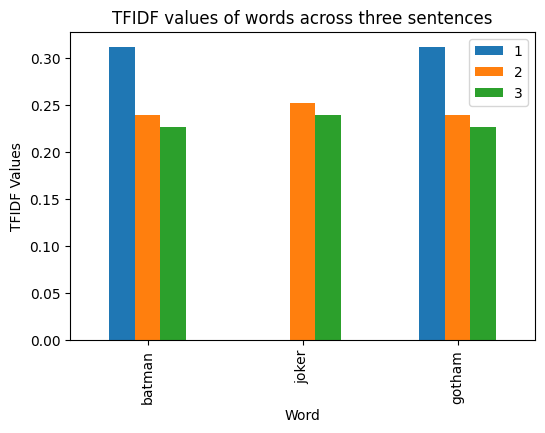

In [60]:
## TFIDF values visualization (Uncomment codes below to see the output)
keywords = ['batman', 'joker', 'gotham']
feature_names = tfidf.get_feature_names_out() # (0.1 marks)

# TFIDF values of keywords in "Batman Begins" description
tfidf_scores_array_1 = tfidf_scores.toarray()[117] # (0.1 marks)
word_tfidf_dict_1 = dict(zip(feature_names, tfidf_scores_array_1)) # (0.1 marks)
tfidf_1 = {word: word_tfidf_dict_1[word] for word in keywords}

# TFIDF values of keywords in "The Dark Knight Rises" description
tfidf_scores_array_2 = tfidf_scores.toarray()[56]
word_tfidf_dict_2 = dict(zip(feature_names, tfidf_scores_array_2))
tfidf_2 = {word: word_tfidf_dict_2[word] for word in keywords}

# TFIDF values of keywords in "The Dark Knight" description
tfidf_scores_array_3 = tfidf_scores.toarray()[2]
word_tfidf_dict_3 = dict(zip(feature_names, tfidf_scores_array_3))
tfidf_3 = {word: word_tfidf_dict_3[word] for word in keywords}

# Create DataFrames
df1 = pd.DataFrame(list(tfidf_1.items()), columns=['Word', '1'])
df2 = pd.DataFrame(list(tfidf_2.items()), columns=['Word', '2'])
df3 = pd.DataFrame(list(tfidf_3.items()), columns=['Word', '3'])

# Merge DataFrames on 'Word'
merged_df = pd.merge(df1, df2, on='Word')
merged_df = pd.merge(merged_df, df3, on='Word')

# Plotting
ax = merged_df.plot(kind='bar', x='Word', figsize=(6,4))

# Adding labels and title
ax.set_xlabel('Word')
ax.set_ylabel('TFIDF Values')
plt.title('TFIDF values of words across three sentences')

# Show the plot
plt.show()